## Семинар 3 "Определение ключевых точек лица"

ФИО: Елохов Арутр Владимирович

# Подготовительная задача 1

Сделать из линейной регрессии nn.sequental двухслойную сеть

In [14]:
import warnings
warnings.filterwarnings("ignore")
from __future__ import print_function, division
import matplotlib.pyplot as plt
import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms, utils
from sklearn.metrics import accuracy_score, mean_squared_error
from torch.autograd import Variable
import numpy as np
import pandas as pd
import scipy
import torch
%matplotlib inline

In [2]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, D_in, D_mid, D_out, activation="sigm"):
        super(NeuralNetwork, self).__init__()
        
        if(activation == "elu"):
            self.Sequential = torch.nn.Sequential(torch.nn.Linear(D_in, D_mid), 
                                                  torch.nn.ELU(), 
                                                  torch.nn.Linear(D_mid, D_out))
        elif(activation =="relu"):
            self.Sequential = torch.nn.Sequential(torch.nn.Linear(D_in, D_mid), 
                                                  torch.nn.ReLU(), 
                                                  torch.nn.Linear(D_mid, D_out))
        else:
            self.Sequential = torch.nn.Sequential(torch.nn.Linear(D_in, D_mid), 
                                                  torch.nn.Sigmoid(), 
                                                  torch.nn.Linear(D_mid, D_out))  
        return
    
    def forward(self, X):
        return self.Sequential(X)    

# Подготовительная задача 2

Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST
(повторить первый и второй пункты из прошлого задания )

In [3]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('.', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
D_in, D_mid, D_out = 784, 100, 10
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

In [5]:
def loss_and_accuracy(model, train, test, Epoch=10, learning_rate=0.001):
    Loss_train = []
    Loss_test = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in xrange(Epoch):
        L_train = []
        L_test = []
        for X, y in train:
            X = X.view(X.size(0), -1)
            X_var = Variable(X)
            y_var = Variable(y, requires_grad=False)
            y_pred = model(X_var)
            loss = loss_fn(y_pred, y_var)
            L_train.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        for X, y in test:
            X = X.view(X.size(0), -1)
            X_var = Variable(X)
            y_var = Variable(y, requires_grad=False)
            y_pred = model(X_var)
            loss = loss_fn(y_pred, y_var)
            L_test.append(loss.data[0])
        Loss_train.append(sum(L_train)/len(L_train))
        Loss_test.append(sum(L_test)/len(L_test))
    axis_x = np.arange(1, Epoch + 1)
    axis_y1 = np.array(Loss_train)
    axis_y2 = np.array(Loss_test)
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(20,8))
        plt.plot(axis_x, axis_y1, linewidth=2.0)
        plt.plot(axis_x, axis_y2, linewidth=2.0)
        plt.xlabel('Epoch')
        plt.ylabel('NLL')
        plt.legend(['train', 'test'])
        plt.show()
    Scores = []
    for X, y in test:
        X = X.view(X.size(0), -1)
        X_var = Variable(X)
        y_var = Variable(y, requires_grad=False)
        y_predicted = model(X_var)
        Scores.append(accuracy_score(y.numpy(), np.argmax(y_predicted.data.numpy(), axis=1)))
    print("Accuracy: %f" %(sum(Scores)/len(Scores)))
    return

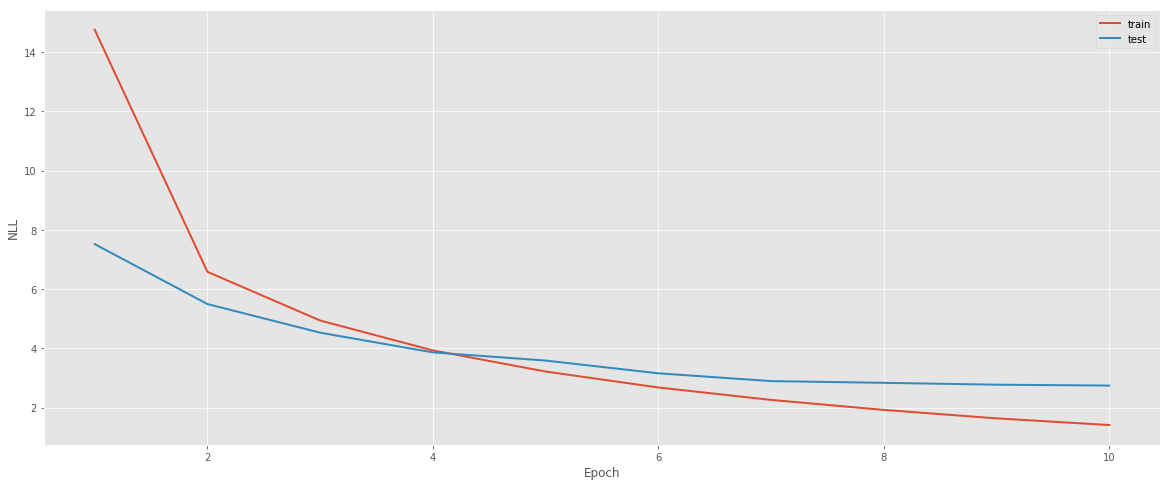

Accuracy: 0.973742


In [6]:
model = NeuralNetwork(D_in, D_mid, D_out)
loss_and_accuracy(model, train_loader, test_loader)

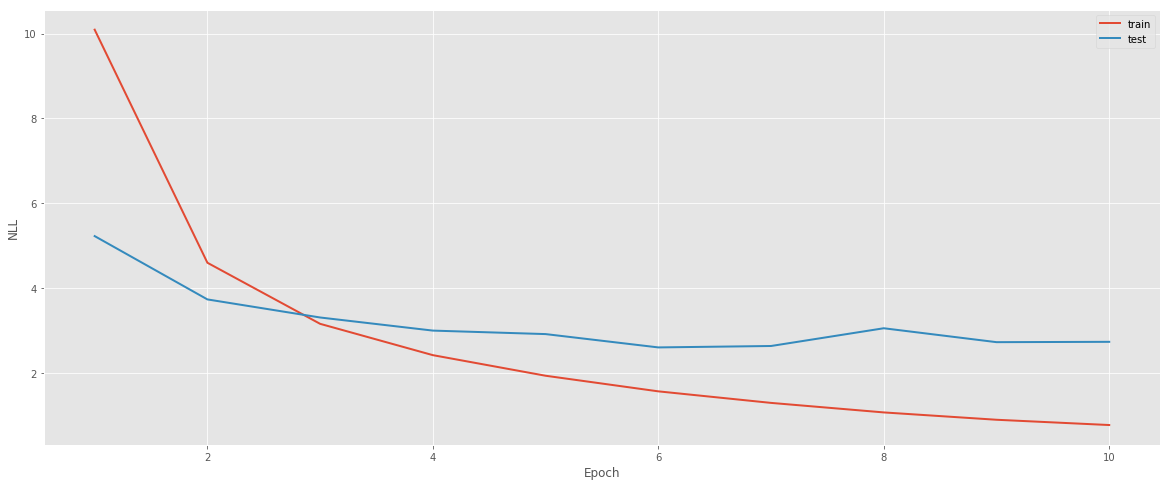

Accuracy: 0.976737


In [7]:
model = NeuralNetwork(D_in, D_mid, D_out, "relu")
loss_and_accuracy(model, train_loader, test_loader)

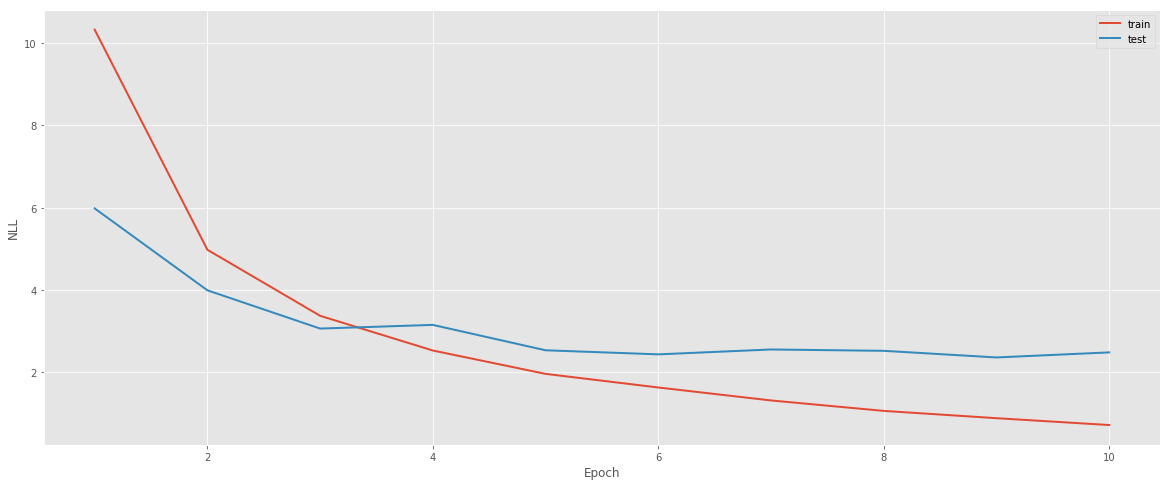

Accuracy: 0.977336


In [8]:
model = NeuralNetwork(D_in, D_mid, D_out, "elu")
loss_and_accuracy(model, train_loader, test_loader)

## Задание

Используя датасет с особенными точками лица из лекции, разбейте данные на train / test и решите задачу регрессии для поиска 15-ти особых точек. Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).

In [15]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [16]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [17]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    plt.imshow(images_batch.transpose(0, 1).contiguous().view(im_size, im_size*batch_size).numpy(), cmap='gray')

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')
    return

In [18]:
train_data = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                           root_dir='dataset/train/',
                                           transform=transforms.Compose([
                                               Rescale(96),
                                               RandomCrop(90),
                                               ToTensor()
                                           ]))
test_data = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                           root_dir='dataset/test/',
                                           transform=transforms.Compose([
                                               Rescale(96),
                                               RandomCrop(90),
                                               ToTensor()
                                           ]))

train_loader = DataLoader(train_data, batch_size=8,
                        shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=8,
                        shuffle=True, num_workers=4)

0


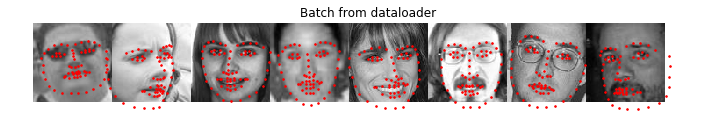

1


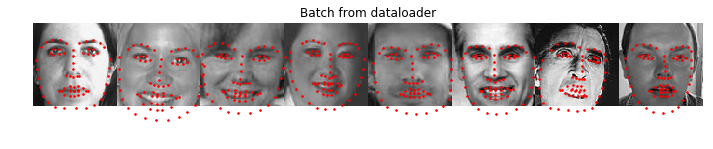

2


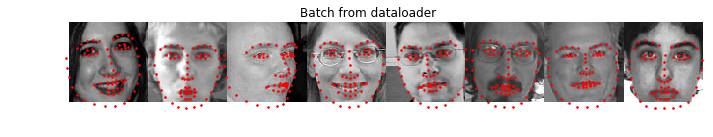

In [19]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch)
    plt.figure(figsize=(12,6))
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    if( i_batch == 2):
        break

In [20]:
def apply_model(model, train, test, Epoch=3, learning_rate=0.01):
    Loss_train = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in xrange(Epoch):
        L_train = []
        for sample_batched in train:
            X, y = sample_batched['image'], sample_batched['landmarks']
            X = X.view(X.size(0), -1).float()
            y = y.view(y.size(0), -1).float()
            X_var = Variable(X)
            y_var = Variable(y, requires_grad=False)
            y_pred = model(X_var)
            loss = loss_fn(y_pred, y_var)
            L_train.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        Loss_train.append(sum(L_train)/len(L_train))
    axis_x = np.arange(1, Epoch + 1)
    axis_y1 = np.array(Loss_train)
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(20,8))
        plt.plot(axis_x, axis_y1, linewidth=2.0)
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend(['train'])
        plt.show()
    Scores = []
    for i_batch, sample_batched in enumerate(test):
        X, y = sample_batched['image'], sample_batched['landmarks']
        X = X.view(X.size(0), -1).float()
        size = y.size()
        y = y.view(y.size(0), -1).float()
        X_var = Variable(X)
        y_var = Variable(y, requires_grad=False)
        y_predicted = model(X_var)
        Scores.append(mean_squared_error(y.numpy(), y_predicted.data.numpy()))

        sample_batched['landmarks'] = y_predicted.data.view(size)
        plt.figure(figsize=(12,6))
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        if( i_batch == 2):
            break
    print("MSE: %f" %(sum(Scores)/len(Scores)))
    return

In [21]:
D_in, D_mid, D_out = 90**2, 1000, 136
loss_fn = torch.nn.MSELoss()

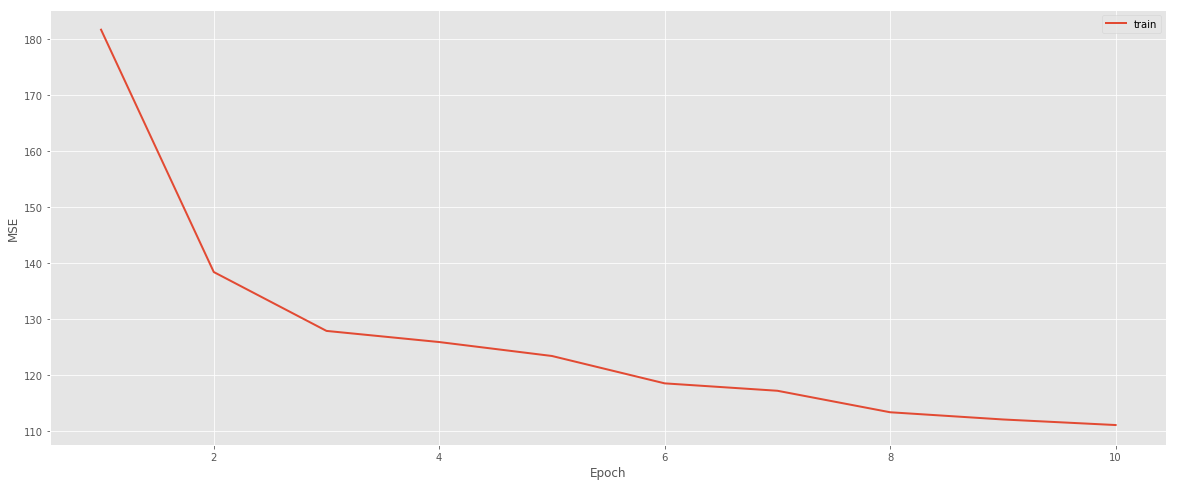

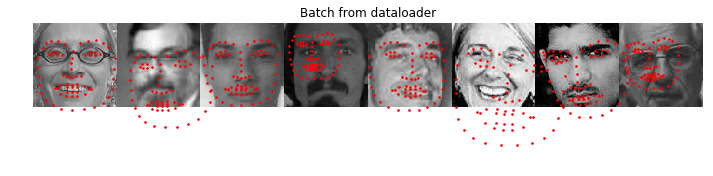

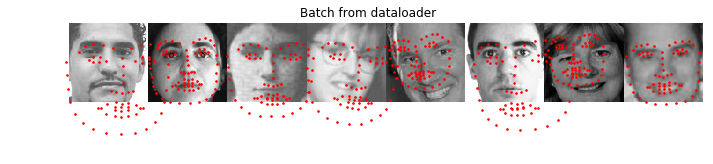

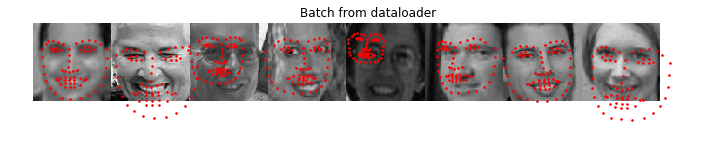

MSE: 164.450511


In [22]:
model = torch.nn.Linear(D_in, D_out)
apply_model(model, train_loader, test_loader, Epoch=10, learning_rate=0.001)

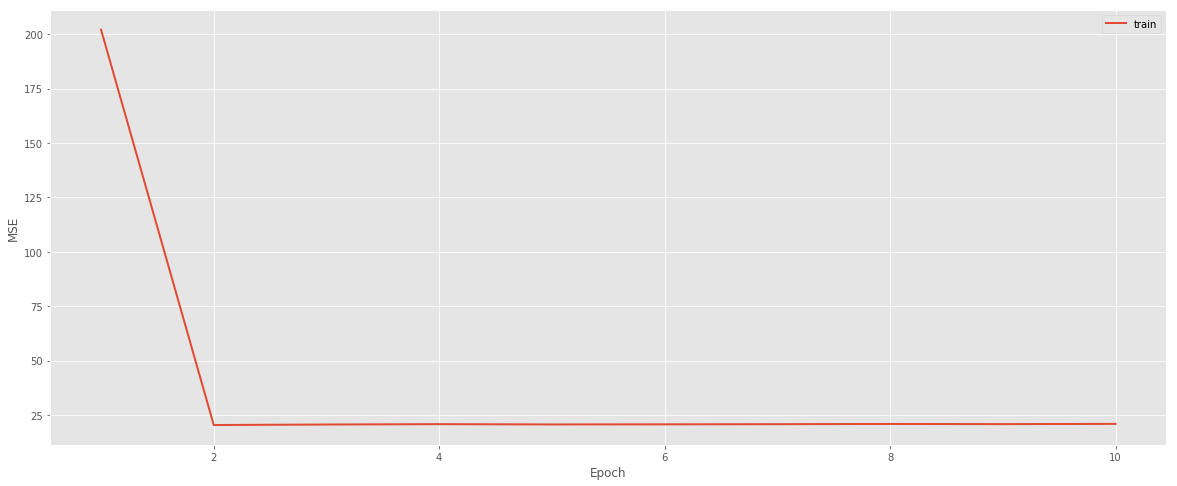

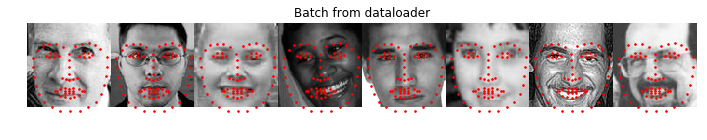

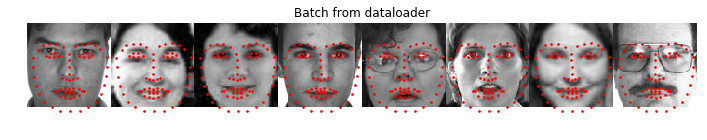

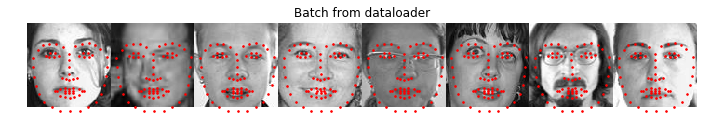

MSE: 17.714948


In [23]:
model = NeuralNetwork(D_in, D_mid, D_out)
apply_model(model, train_loader, test_loader, Epoch=10, learning_rate=0.001)

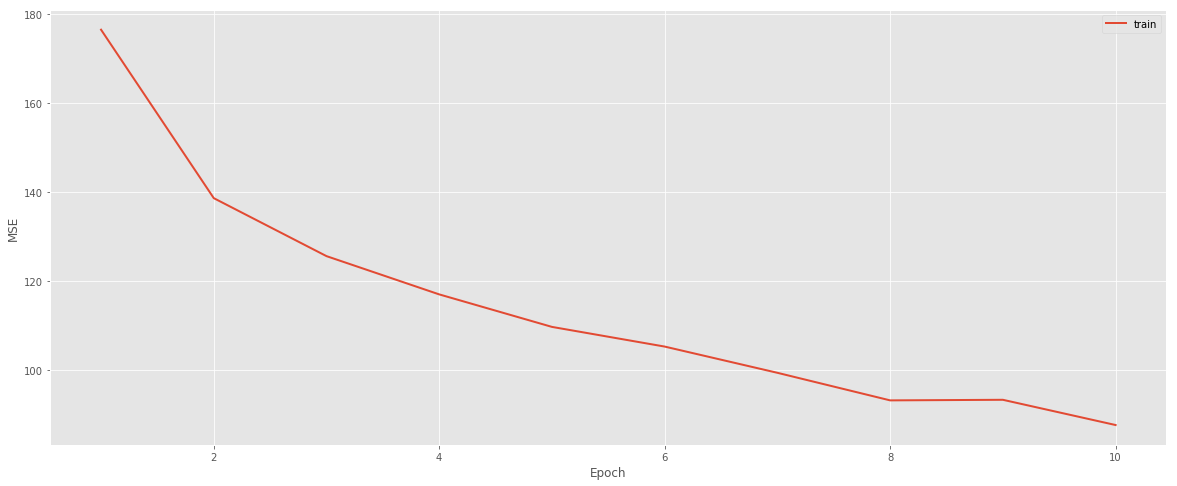

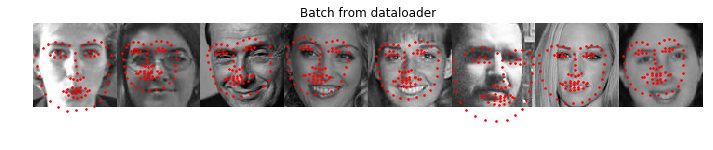

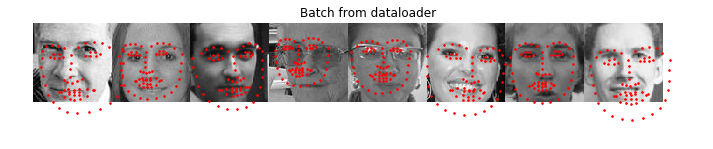

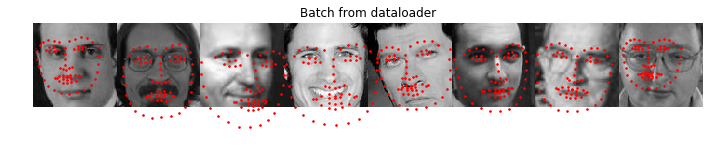

MSE: 71.578762


In [24]:
model = NeuralNetwork(D_in, D_mid, D_out, "relu")
apply_model(model, train_loader, test_loader, Epoch=10, learning_rate=0.001)

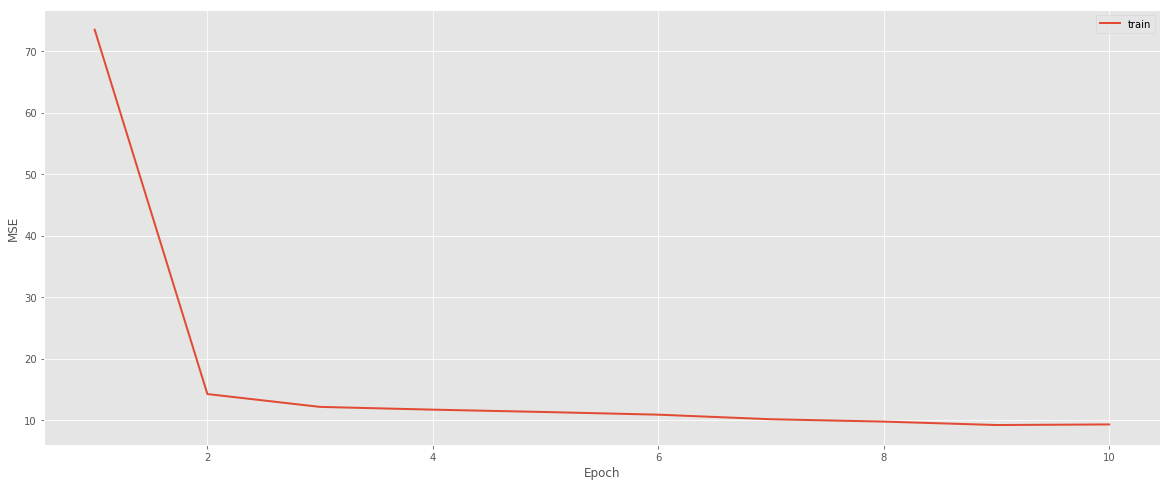

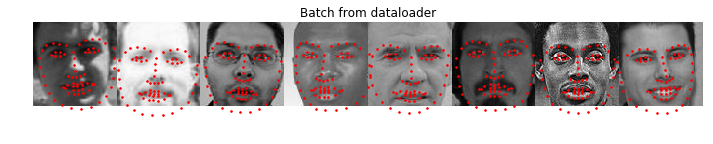

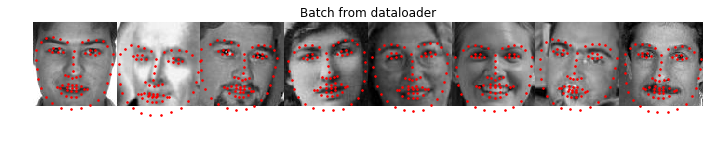

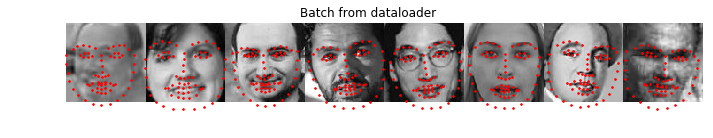

MSE: 9.614893


In [25]:
model = NeuralNetwork(D_in, D_mid, D_out, "elu")
apply_model(model, train_loader, test_loader, Epoch=10, learning_rate=0.001)

In [26]:
image_size = 90
channels = 1
class ConvNet_2(torch.nn.Module):
    def __init__(self):
        super(ConvNet_2, self).__init__()
        self.conv_layers = torch.nn.Sequential(torch.nn.Conv2d(channels, 8, 3, padding=1), 
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(8, 16, 3, padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(2),
                                         torch.nn.Conv2d(16, 32, 3, padding=1))
        self.linear_layers = torch.nn.Sequential(torch.nn.Linear(image_size//2*image_size//2*32, 136))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [27]:
def apply_conv_model(model, train, test, Epoch=1, learning_rate=0.01):
    Loss_train = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in xrange(Epoch):
        L_train = []
        for i_batch, sample_batched in enumerate(train):
            X, y = sample_batched['image'], sample_batched['landmarks']
            X = X.view(X.size(0), 1, X.size(1), -1).float()
            y = y.float()
            X_var = Variable(X)
            y_var = Variable(y, requires_grad=False)
            y_pred = model(X_var)
            loss = loss_fn(y_pred, y_var)
            L_train.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        Loss_train.append(sum(L_train)/len(L_train))
    axis_x = np.arange(1, Epoch + 1)
    axis_y1 = np.array(Loss_train)
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(20,8))
        plt.plot(axis_x, axis_y1, linewidth=2.0)
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.legend(['train'])
        plt.show()
    Scores = []
    for i_batch, sample_batched in enumerate(test):
        X, y = sample_batched['image'], sample_batched['landmarks']
        X = X.view(X.size(0), 1, X.size(1), -1).float()
        y = y.float()
        size = y.size()
        X_var = Variable(X)
        y_var = Variable(y, requires_grad=False)
        y_predicted = model(X_var)
        Scores.append(mean_squared_error(y.view(y.size(0), -1).float().numpy(), y_predicted.data.view(y.size(0), -1).float().numpy()))

        sample_batched['landmarks'] = y_predicted.data.view(size)
        plt.figure(figsize=(12,6))
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        if( i_batch == 2):
            break
    print("MSE: %f" %(sum(Scores)/len(Scores)))
    return

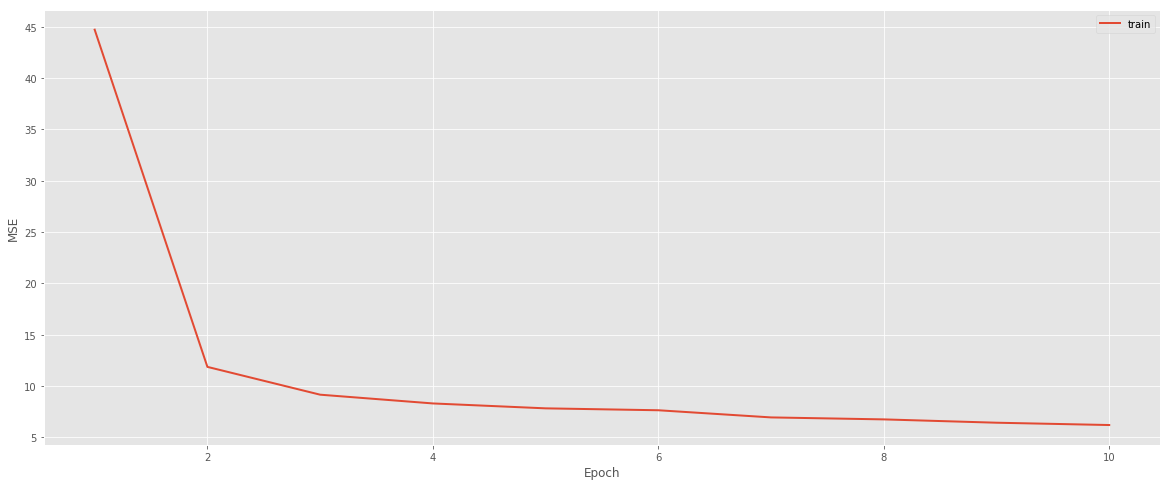

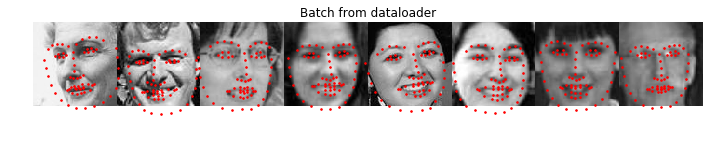

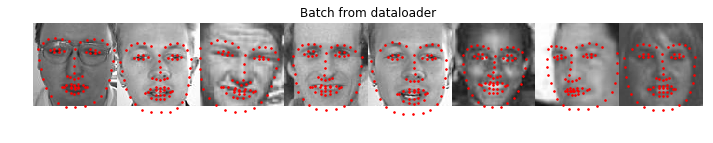

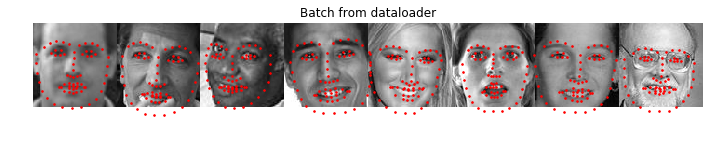

MSE: 5.599531


In [28]:
model = ConvNet_2()
apply_conv_model(model, train_loader, test_loader, Epoch=10, learning_rate=0.001)